In [1]:
import sys
sys.path.append("../")

In [71]:

import os
import pandas as pd
import numpy as np
from model.inference import *
from model.parameter import *
from model.structure import *
from pyvis.network import Network
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import teneto
import pathpy as pp
from teneto import TemporalNetwork

from pathpy.classes import dag



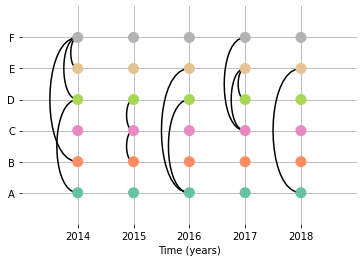

In [63]:
import matplotlib.pyplot as plt
tlabs = ['2014','2015','2016','2017','2018']
tunit = 'years'
nlabs = ['A', 'B', 'C', 'D', 'E', 'F']
size = (len(nlabs), len(tlabs))
tnet = TemporalNetwork()
tnet = TemporalNetwork(nodelabels=nlabs, timeunit=tunit, timelabels=tlabs, nettype='bu')
C2 = tnet.generatenetwork('rand_binomial',size=size, prob=0.2)
tnet.plot('slice_plot', cmap='Set2')
plt.show()

In [64]:
mapper = {}

for index, value in enumerate(nlabs):
    mapper[index] = value
    

In [65]:
df = tnet.network
df["i"].replace(mapper, inplace=True)
df["j"].replace(mapper, inplace=True)

In [66]:

edge_list_time = list(df.itertuples(index=False, name=None))

In [97]:
t = pp.TemporalNetwork()
for p in edge_list_time:
    t.add_edge(*p)
print(t)
style = {    
  'ts_per_frame': 1, 
  'ms_per_frame': 2000,
  'look_ahead': 2, 
  'look_behind': 2, 
  'node_size': 15, 
  'inactive_edge_width': 2,
  'active_edge_width': 4, 
  'label_color' : '#ffffff',
  'label_size' : '24px',
  'label_offset': [0,5]
  }

Nodes:			6
Time-stamped links:	12
Links/Nodes:		2.0
Observation period:	[0, 4]
Observation length:	 4 
Time stamps:		 5 
Avg. inter-event dt:	 1.0
Min/Max inter-event dt:	 1/1


In [98]:

pp.visualisation.plot(t, **style)
pp.visualisation.export_html(t, 'outputs/my_temporal_network.html', **style)

### time-unfolded DAG

In [105]:
p = pp.path_extraction.temporal_paths.paths_from_temporal_network_dag(t, delta=1)
print(p)

for l in p.paths:
    for x in p.paths[l]:
        if p.paths[l][x][1]>0:
            print('{0} -> {1}'.format(x, p.paths[l][x][1]))

2021-08-08 23:29:01 [Severity.INFO]	Constructing time-unfolded DAG ...
2021-08-08 23:29:01 [Severity.INFO]	finished.
Directed Acyclic Graph
Nodes:		18
Roots:		9
Leaves:		8
Links:		12
Acyclic:	None

2021-08-08 23:29:01 [Severity.INFO]	Generating causal trees for 9 root nodes ...
2021-08-08 23:29:01 [Severity.INFO]	finished.
Total path count: 		11.0 
[Unique / Sub paths / Total]: 	[10.0 / 25.0 / 36.0]
Nodes:				6 
Edges:				10
Max. path length:		2
Avg path length:		1.0909090909090908 
Paths of length k = 0		0.0 [ 0.0 / 23.0 / 23.0 ]
Paths of length k = 1		10.0 [ 9.0 / 2.0 / 12.0 ]
Paths of length k = 2		1.0 [ 1.0 / 0.0 / 1.0 ]

('E', 'F') -> 1.0
('A', 'E') -> 2.0
('A', 'D') -> 1.0
('C', 'D') -> 1.0
('C', 'E') -> 1.0
('C', 'F') -> 1.0
('D', 'F') -> 1.0
('B', 'F') -> 1.0
('B', 'C') -> 1.0
('A', 'D', 'E') -> 1.0


### Higher order network models

### First order

In [166]:

hon_1 = pp.HigherOrderNetwork(p, k=1)
style = { 
    'label_offset': [0,-1], 
    'label_color' : 'black', 
    'width': 900, 
    'height': 550,
    'node_size':30.0,#note: this has to be float
    #'force_repel':-5000,
    'force_charge':-4000,
    'label_size' : '24px',
    
}
pp.visualisation.plot(hon_1, **style)

for e in hon_1.edges:
    print(e, hon_1.edges[e]['weight'])

('E', 'F') [0. 1.]
('A', 'E') [0. 2.]
('A', 'D') [1. 1.]
('D', 'E') [1. 0.]
('C', 'D') [0. 1.]
('C', 'E') [0. 1.]
('C', 'F') [0. 1.]
('D', 'F') [0. 1.]
('B', 'F') [0. 1.]
('B', 'C') [0. 1.]


### Second order

In [178]:

hon_2 = pp.HigherOrderNetwork(p, k=2)

style = { 
    'label_offset': [0,-1], 
    'label_color' : 'black', 
    'width': 900, 
    'height': 550,
    'node_size':20.0,#note: this has to be float
    'force_repel':-500,
    'label_size' : '14px',
    
}
pp.visualisation.plot(hon_2, **style)

for e in hon_2.edges:
    print(e, hon_2.edges[e]['weight'])

('A,D', 'D,E') [0. 1.]


### Null models for paths within the space of possible second-order models. 

This allows us to compare how the observed path statistics deviate from a (Markovian) expectation (e..g we expect paths a->c->d and a->c->e to occur with the same probability, i.e. the next nodes d or e on a path through c are independent from the previous node a, their probabilities only depending on the relative frequency of edges (c,d) vs. (c,e).

In [168]:
hon_2_null = pp.HigherOrderNetwork(p, k=2, null_model=True)
pp.visualisation.plot(hon_2_null, **style)

for e in hon_2_null.edges:
    print(e, hon_2_null.edges[e])

('A,E', 'E,F') {'weight': array([0., 2.])}
('A,D', 'D,E') {'weight': array([0., 1.])}
('A,D', 'D,F') {'weight': array([0., 1.])}
('D,E', 'E,F') {'weight': array([0., 1.])}
('C,D', 'D,E') {'weight': array([0. , 0.5])}
('C,D', 'D,F') {'weight': array([0. , 0.5])}
('C,E', 'E,F') {'weight': array([0., 1.])}
('B,C', 'C,D') {'weight': array([0.        , 0.33333333])}
('B,C', 'C,E') {'weight': array([0.        , 0.33333333])}
('B,C', 'C,F') {'weight': array([0.        , 0.33333333])}


### Finding optimal higher order models

In [180]:
mog = pp.MultiOrderModel(p, max_order=2)
print('Optimal order = ', mog.estimate_order(p))

2021-08-09 00:37:51 [Severity.INFO]	Generating 0-th order layer ...
2021-08-09 00:37:51 [Severity.INFO]	Generating 1-th order layer ...
2021-08-09 00:37:51 [Severity.INFO]	Generating 2-th order layer ...
2021-08-09 00:37:51 [Severity.INFO]	finished.
2021-08-09 00:37:52 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = 1.3862943611198943
2021-08-09 00:37:52 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 6
2021-08-09 00:37:52 [Severity.INFO]	Likelihood ratio test, p = 0.9666868437595227
Optimal order =  1
